# Detector simulation
In this notebook we load a track dataset generated by `edep-sim` and we calculate the ADC counts corresponding to each pixel. The result is exported to a HDF5 file.

In [2]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
from math import ceil
from time import time

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import cupy as cp
import fire
import h5py

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from tqdm.notebook import tqdm

In [4]:
from larndsim import consts
import importlib
importlib.reload(consts)
consts.load_detector_properties("../larndsim/detector_properties/ndlar-module.yaml","../larndsim/pixel_layouts/multi_tile_layout-3.0.40.yaml")

from larndsim import quenching, drifting, detsim, pixels_from_track, fee

In [5]:
response = cp.load('../larndsim/response_38.npy')

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [6]:
with h5py.File('lbnfSpillLAr.edep.h5', 'r') as f:
    tracks = np.array(f['segments'])
    
selected_tracks = tracks[:100]
    
x_start = np.copy(selected_tracks['x_start'] )
x_end = np.copy(selected_tracks['x_end'])
x = np.copy(selected_tracks['x'])

selected_tracks['x_start'] = np.copy(selected_tracks['z_start'])
selected_tracks['x_end'] = np.copy(selected_tracks['z_end'])
selected_tracks['x'] = np.copy(selected_tracks['z'])

selected_tracks['z_start'] = x_start
selected_tracks['z_end'] = x_end
selected_tracks['z'] = x
# selected_tracks['eventID'] = 0

In [7]:
import numpy.lib.recfunctions as rfn

if 'n_photons' not in selected_tracks.dtype.names:
    n_photons = np.zeros(selected_tracks.shape[0], dtype=[('n_photons', 'f4')])
    selected_tracks = rfn.merge_arrays((selected_tracks, n_photons), flatten=True)

### Quenching and drifting
We calculate the number of electrons after recombination (`quenching` module) and the position and number of electrons after drifting (`drifting` module).

In [8]:
%load_ext wurlitzer
importlib.reload(drifting)
TPB = 256
BPG = ceil(selected_tracks.shape[0] / TPB)
quenching.quench[BPG,TPB](selected_tracks, consts.birks)
drifting.drift[BPG,TPB](selected_tracks)

We find the pixels intersected by the projection of the tracks on the anode plane using the Bresenham's algorithm. We also take into account the neighboring pixels, due to the transverse diffusion of the charges.

In [9]:
importlib.reload(pixels_from_track)
unique_eventIDs = cp.unique(selected_tracks['eventID'])

longest_pix = ceil(max(selected_tracks["dx"])/consts.pixel_pitch)
max_radius = ceil(max(selected_tracks["tran_diff"])*5/consts.pixel_pitch)

TPB = 128
BPG = ceil(selected_tracks.shape[0] / TPB)

max_pixels = np.array([0])
pixels_from_track.max_pixels[BPG,TPB](selected_tracks, max_pixels)

max_neighboring_pixels = (2*max_radius+1)*max_pixels[0]+(1+2*max_radius)*max_radius*2
active_pixels = cp.full((selected_tracks.shape[0], max_pixels[0]), -1, dtype=np.int32)
neighboring_pixels = cp.full((selected_tracks.shape[0], max_neighboring_pixels), -1, dtype=np.int32)
n_pixels_list = cp.zeros(shape=(selected_tracks.shape[0]))

pixels_from_track.get_pixels[BPG,TPB](selected_tracks,
                                      active_pixels,
                                      neighboring_pixels,
                                      n_pixels_list,
                                      max_radius)



In [10]:
shapes = neighboring_pixels.shape
joined = neighboring_pixels.reshape(shapes[0]*shapes[1])
unique_pix = cp.unique(joined)
unique_pix = unique_pix[(unique_pix != -1),:]

### Charge distribution calculation
Here we calculate the current induced by each track on the pixels, taking into account longitudinal and transverse diffusion. The track segment is parametrized as:
\begin{align}
x'(r') &=x_s + \frac{\Delta x}{\Delta r}r'\\
y'(r') &=y_s + \frac{\Delta y}{\Delta r}r'\\
z'(r') &=z_s + \frac{\Delta z}{\Delta r}r',
\end{align}
where $\Delta r$ is the segment length. Here we assume $z$ as the drift direction.
The diffused charge distribution is calculated with the following integral:
\begin{equation}
\rho(x,y,z) = \frac{Q}{\sqrt{(2\pi)^3}\sigma_x\sigma_y\sigma_z\Delta r}\exp\left[-\frac{(x-x_s)^2}{2\sigma_x^2}-\frac{(y-y_s)^2}{2\sigma_y^2}-\frac{(z-z_s)^2}{2\sigma_z^2}\right]\int^{r'=\Delta r}_{r'=0}dr'\exp[-(ar'^2+br')],
\end{equation}
where 
\begin{align}
a &= \left[\left(\frac{\Delta x}{\Delta r}\right)^2\frac{1}{2\sigma_x^2} + \left(\frac{\Delta y}{\Delta r}\right)^2\frac{1}{2\sigma_y^2} + \left(\frac{\Delta z}{\Delta r}\right)^2\frac{1}{2\sigma_z^2} \right]\\
b &= -\left[\frac{(x-x_s)}{\sigma_x^2}\frac{\Delta x}{\Delta r}+
\frac{(y-y_s)}{\sigma_y^2}\frac{\Delta y}{\Delta r}+
\frac{(z-z_s)}{\sigma_z^2}\frac{\Delta z}{\Delta r}\right].
\end{align}

The simmetry of the transverse diffusion along the track allows to take a slice on the $xy$ plane and solve the integral once at a fixed $z$ coordinate (e.g. at $z_{m} = (z_s+z_e)/2$) and re-use it at other $z$ coordinates away from the endpoints (where $\rho(x,y,z)$ varies along $z$ so must be calculated at each $z$). 

In [11]:
max_length = cp.array([0])
track_starts = cp.empty(selected_tracks.shape[0])
threadsperblock = 128
blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
detsim.time_intervals[blockspergrid,threadsperblock](track_starts, max_length, selected_tracks)

signals = cp.zeros((selected_tracks.shape[0],
                    neighboring_pixels.shape[1],
                    cp.asnumpy(max_length)[0]), dtype=np.float32)
threadsperblock = (1,1,64)
importlib.reload(detsim)
blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
detsim.tracks_current[blockspergrid,threadsperblock](signals,
                                                     neighboring_pixels,
                                                     selected_tracks,
                                                     response)

Here we create a map that associates each track to the pixels where it induces a current

In [12]:
pixel_index_map = cp.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)
for i_ in range(selected_tracks.shape[0]):
    compare = neighboring_pixels[i_, ..., cp.newaxis] == unique_pix
    indices = cp.where(compare)
    pixel_index_map[i_, indices[0]] = indices[1]

The three-dimensional array can contain more than one signal for each pixel at different times. If we want to plot the full induced signal on the pixel, we need to join the signals corresponding to the same pixel. First, we find the start time of each signal with `time_intervals`:

In [13]:
# Mapping between unique pixel array and track array index
track_pixel_map = cp.full((unique_pix.shape[0], detsim.MAX_TRACKS_PER_PIXEL), -1)
TPB = 32
BPG = ceil(unique_pix.shape[0] / TPB)
detsim.get_track_pixel_map[BPG, TPB](track_pixel_map, unique_pix, neighboring_pixels)

threadsperblock = (1,1,64)
blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
pixels_signals = cp.zeros((len(unique_pix), len(consts.time_ticks)*3))
pixels_tracks_signals = cp.zeros((len(unique_pix),len(consts.time_ticks)*3,track_pixel_map.shape[1]))

detsim.sum_pixel_signals[blockspergrid,threadsperblock](pixels_signals,
                                                        signals,
                                                        track_starts,
                                                        pixel_index_map,
                                                        track_pixel_map,
                                                        pixels_tracks_signals)
currents = cp.sum(pixels_signals,axis=1)*consts.t_sampling/consts.e_charge

Now, let's verify that the integral of our induced currents 

In [14]:
print("Ratio: ", sum(currents)/sum(selected_tracks['n_electrons']))

Ratio:  0.9604029667223107


### 3D event display

In [ ]:
cmap = cm.Spectral_r
importlib.reload(pixels_from_track)
from matplotlib import colors
norm = colors.Normalize(vmin=0, vmax=256)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cmap = cm.viridis
norm_curr = colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
m_curr = cm.ScalarMappable(norm=norm_curr, cmap=cmap)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for it,t in enumerate(selected_tracks):
    if it == 0:
        ax.plot((t["x_start"], t["x_end"]), 
            (t["z_start"], t["z_end"]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            alpha=1,
            zorder=10,
            label='Geant4 detector segment')
    else:
        ax.plot((t["x_start"], t["x_end"]), 
                (t["z_start"], t["z_end"]),
                (t["y_start"], t["y_end"]),
                c='r',
                lw=1,
                alpha=1,
                zorder=9999)
    #print(t['pixel_plane'])
    if 0<=t['pixel_plane']<=999:
        ax.plot((t["x_start"], t["x_end"]), 
            (consts.tpc_borders[t['pixel_plane']][2][0], consts.tpc_borders[t['pixel_plane']][2][0]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            ls=':',
            alpha=1,
            zorder=9999)
        
for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p.get())
    _,_,pixel_plane = pixels_from_track.id2pixel(p.get())
    #print(pixel_plane)
    row = int(pixel_plane // 4)
    column = int(pixel_plane % 4)
    if currents[ip] > 0:
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.1, fc=m_curr.to_rgba(currents[ip].get()),
                             edgecolor='gray')
        ax.add_patch(rect)
        art3d.pathpatch_2d_to_3d(rect, z=consts.tpc_borders[pixel_plane][2][0], zdir="y")
        
        
for it in range(0,70,2):
    anode1 = plt.Rectangle((consts.tpc_borders[it][0][0], consts.tpc_borders[it][1][0]),
                            consts.tpc_borders[it][0][1]-consts.tpc_borders[it][0][0], 
                            consts.tpc_borders[it][1][1]-consts.tpc_borders[it][1][0],
                           linewidth=1, fc='none',
                           edgecolor='gray', label=('Pixel' if ip == 5 else ''))
    ax.add_patch(anode1)
    art3d.pathpatch_2d_to_3d(anode1, z=consts.tpc_borders[0][2][0], zdir="y")

    anode2 = plt.Rectangle((consts.tpc_borders[it][0][0], consts.tpc_borders[it][1][0]),
                            consts.tpc_borders[it][0][1]-consts.tpc_borders[it][0][0], 
                            consts.tpc_borders[it][1][1]-consts.tpc_borders[it][1][0],
                           linewidth=1, fc='none',
                           edgecolor='gray', label=('Pixel' if ip == 5 else ''))
    ax.add_patch(anode2)
    art3d.pathpatch_2d_to_3d(anode2, z=consts.tpc_borders[it+1][2][0], zdir="y")

    cathode = plt.Rectangle((consts.tpc_borders[it][0][0], consts.tpc_borders[it][1][0]),
                            consts.tpc_borders[it][0][1]-consts.tpc_borders[it][0][0], 
                            consts.tpc_borders[it][1][1]-consts.tpc_borders[it][1][0],
                            linewidth=1, fc='gray', alpha=0.2,
                            edgecolor='gray')
    ax.add_patch(cathode)
    z_cathode = (consts.tpc_borders[it][2][0]+consts.tpc_borders[it+1][2][0])/2
    art3d.pathpatch_2d_to_3d(cathode, z=z_cathode, zdir="y")

    ax.plot((consts.tpc_borders[it][0][0],consts.tpc_borders[it][0][0]),(consts.tpc_borders[it][2][0],consts.tpc_borders[it+1][2][0]),
            (consts.tpc_borders[it][1][0],consts.tpc_borders[it][1][0]), lw=1,color='gray')

    ax.plot((consts.tpc_borders[it][0][0],consts.tpc_borders[it][0][0]),(consts.tpc_borders[it][2][0],consts.tpc_borders[it+1][2][0]),
            (consts.tpc_borders[it][1][1],consts.tpc_borders[it][1][1]), lw=1,color='gray')

    ax.plot((consts.tpc_borders[it][0][1],consts.tpc_borders[it][0][1]),(consts.tpc_borders[it][2][0],consts.tpc_borders[it+1][2][0]),
            (consts.tpc_borders[it][1][0],consts.tpc_borders[it][1][0]), lw=1,color='gray')

    ax.plot((consts.tpc_borders[it][0][1],consts.tpc_borders[it][0][1]),(consts.tpc_borders[it][2][0],consts.tpc_borders[it+1][2][0]),
            (consts.tpc_borders[it][1][1],consts.tpc_borders[it][1][1]), lw=1,color='gray')

# ax.set_ylim(consts.module_borders[pixel_plane][2][0],50)
ax.set_xlim(consts.tpc_borders[0][0][0],consts.tpc_borders[-1][0][1])
ax.set_ylim(consts.tpc_borders[0][2][0],consts.tpc_borders[-1][2][0])
ax.set_zlim(consts.tpc_borders[0][1][0],consts.tpc_borders[-1][1][1])

ax.set_box_aspect((4,8,4))
ax.grid(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
# ax.set_axis_off()
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.view_init(azim=10)
def rotate(angle):
    ax.view_init(azim=angle)
    
from matplotlib import animation

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=50)

ax.set_ylabel("z [cm]")
ax.set_xlabel("x [cm]")
ax.set_zlabel("y [cm]")
_ = plt.colorbar(m_curr,fraction=0.035, pad=0.05,label='Induced current integral [# electrons]')


In [14]:
#rot_animation.save('animation.gif', writer='imagemagick', fps=10, bitrate=10, dpi=100)

### Electronics response and digitization 
Here we simulate the electronics response (the self-triggering cycle) and the signal digitization.

In [15]:
from larndsim.cuda_dict import CudaDict

time_ticks = cp.linspace(0, len(unique_eventIDs)*consts.time_interval[1]*3, pixels_signals.shape[1]+1)
integral_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
adc_ticks_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
TPB = 128
BPG = ceil(pixels_signals.shape[0] / TPB)
rng_states = create_xoroshiro128p_states(TPB * BPG, seed=2)
integrate = cp.zeros((pixels_signals.shape[0], time_ticks.shape[0]))
backtracked_ids = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES, track_pixel_map.shape[1]))
pixel_thresholds_lut = CudaDict(cp.array([fee.DISCRIMINATION_THRESHOLD]), 1, 1)
pixel_thresholds_lut.tpb = TPB
pixel_thresholds_lut.bpg = BPG
orig_shape = unique_pix.shape
pixel_thresholds = pixel_thresholds_lut[unique_pix.ravel()].reshape(orig_shape)
fee.get_adc_values[BPG,TPB](pixels_signals,
                            pixels_tracks_signals,
                            time_ticks,
                            integral_list,
                            adc_ticks_list,
                            0,
                            rng_states,
                            backtracked_ids,
                            pixel_thresholds)
adc_list = fee.digitize(integral_list)

As an example, we plot the pixel with the largest amount of deposited charge

In [16]:
largest_pix = np.argmax(pixels_signals.sum(axis=1)).get()

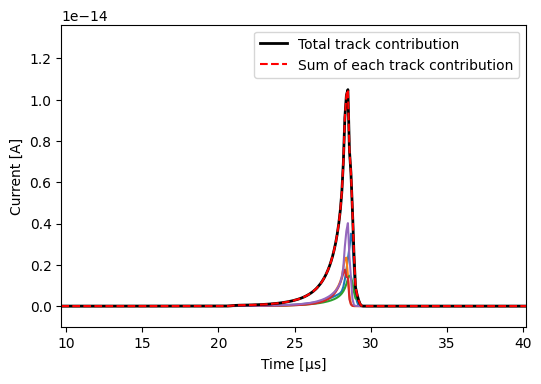

In [17]:
fig,ax=plt.subplots(1,1)
current = pixels_signals[largest_pix][:3201].get()
ax.plot(consts.time_ticks,pixels_tracks_signals[largest_pix][:3201].get())
ax.plot(consts.time_ticks,current,label='Total track contribution',c='k',lw=2)
ax.plot(consts.time_ticks,np.sum(pixels_tracks_signals[largest_pix][:3201].get(),axis=1),c='r',ls='--',label='Sum of each track contribution')
start_time = np.nonzero(current)[0][0]
end_time = np.nonzero(current)[0][-1]
ax.set_xlim(max(0,consts.time_ticks[start_time]-10),consts.time_ticks[end_time]+10)
ax.set_xlabel(r"Time [$\mathrm{\mu}$s]")
ax.set_ylabel(r"Current [A]")
ax.set_ylim(-0.1e-14, max(current)*1.3)
_=ax.legend()

### 2D event display with induced current and ADC counts

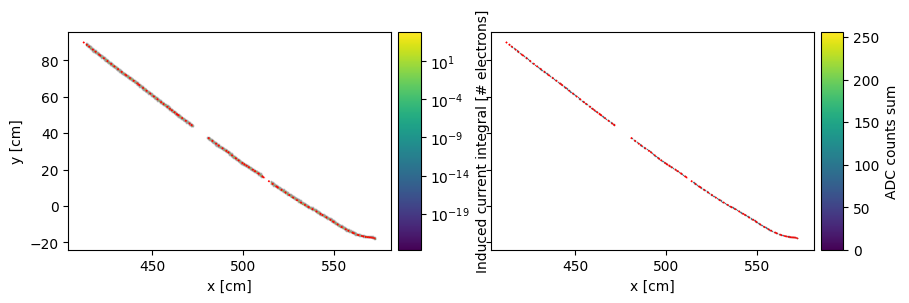

In [18]:
from matplotlib import colors
norm = colors.Normalize(vmin=0, vmax=256)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cmap = cm.viridis
norm_curr = colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
m_curr = cm.ScalarMappable(norm=norm_curr, cmap=cmap)

fig,ax = plt.subplots(1,2,figsize=(10,4.5),sharex=True,sharey=True)
importlib.reload(detsim)
for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p.get())
    _,_,pixel_plane = pixels_from_track.id2pixel(p.get())
    c = currents[ip].get()
    if c >= 1:    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc=m_curr.to_rgba(c),
                             edgecolor='grey')
        ax[0].add_patch(rect)
    else:
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc='none',
                             edgecolor='grey')
        ax[0].add_patch(rect)
    a = adc_list[ip][adc_list[ip]>fee.digitize(0)]
    if len(a):    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc=m.to_rgba(np.sum(a.get())),
                             edgecolor='grey')
        ax[1].add_patch(rect)


for it,t in enumerate(selected_tracks):
    ax[0].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1.25,
            ls=':',
            alpha=1,
            zorder=10)
    ax[1].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1.25,
            ls=':',
            alpha=1,
            zorder=100)
    ax[0].scatter((t["x_start"], t["x_end"]), 
                  (t["y_start"], t["y_end"]),
                  c='r', s=0, zorder=99999)
    ax[1].scatter((t["x_start"], t["x_end"]), 
                  (t["y_start"], t["y_end"]),
                  c='r', s=0, zorder=99999)       

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[0].set_xlabel("x [cm]")
ax[1].set_xlabel("x [cm]")
ax[0].set_ylabel("y [cm]")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

divider0 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m, ax=ax[1], cax=cax0, label='ADC counts sum')

divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m_curr, ax=ax[0], cax=cax1, label='Induced current integral [# electrons]')

plt.subplots_adjust(hspace=0.5)
fig.savefig("currentadc.pdf")

### Export result
As a last step we backtrack the ADC counts to the Geant4 tracks and we export the result in a HDF5 file.

In [19]:
!rm "LAr.neutrino.100.edep.larnd-fromnotebook.h5"
importlib.reload(fee)
# track_pixel_map=cp.repeat(track_pixel_map[:, cp.newaxis], 10, axis=1)
adc_event_ids = np.full(adc_list.shape, unique_eventIDs[0].get()) # FIXME: only works if looping on a single event
event_id_list = [adc_event_ids]

pc = fee.export_to_hdf5(np.concatenate(event_id_list,axis=0),
                        adc_list.get(),
                        adc_ticks_list.get(),
                        unique_pix.get(),
                        backtracked_ids.get(),
                        track_pixel_map.get(),
                        "LAr.neutrino.100.edep.larnd-fromnotebook.h5")#,
#                        bad_channels=None)

Writing to HDF5...: 100%|████████████████| 1941/1941 [00:00<00:00, 15189.52it/s]


In [20]:
with h5py.File('LAr.neutrino.100.edep.larnd-fromnotebook.h5', 'a') as f:
    f.create_dataset("tracks", data=selected_tracks)

## Analyze the result
Here we read back the file we just produced and compare it with the _true_ tracks. So first we create a dictionary that associates the chip key to a $(x,y)$ position:

In [21]:
from collections import defaultdict
import yaml

geometry_yaml = yaml.load(open("../larndsim/pixel_layouts/multi_tile_layout-3.0.40.yaml"), Loader=yaml.FullLoader)
det_yaml = yaml.load(open("../larndsim/detector_properties/ndlar-module.yaml"),Loader=yaml.FullLoader)

pixel_pitch = geometry_yaml['pixel_pitch']
is_multi_tile = True
chip_channel_to_position = geometry_yaml['chip_channel_to_position']
tile_orientations = geometry_yaml['tile_orientations']
tile_positions = geometry_yaml['tile_positions']
tpc_centers = det_yaml['tpc_offsets']
tile_indeces = geometry_yaml['tile_indeces']
xs = np.array(list(chip_channel_to_position.values()))[:, 0] * pixel_pitch
ys = np.array(list(chip_channel_to_position.values()))[:, 1] * pixel_pitch
x_size = max(xs)-min(xs)+pixel_pitch
y_size = max(ys)-min(ys)+pixel_pitch

def _rotate_pixel(pixel_pos, tile_orientation):
    return pixel_pos[0]*tile_orientation[2], pixel_pos[1]*tile_orientation[1]

tile_geometry = defaultdict(int)
geometry = {}
io_group_io_channel_to_tile = {}

for tile in geometry_yaml['tile_chip_to_io']:
    tile_orientation = tile_orientations[tile]
    tile_geometry[tile] = tile_positions[tile], tile_orientations[tile]
    
    for chip in geometry_yaml['tile_chip_to_io'][tile]:
        io_group_io_channel = geometry_yaml['tile_chip_to_io'][tile][chip]
        io_group = io_group_io_channel//1000
        io_channel = io_group_io_channel % 1000
        io_group_io_channel_to_tile[(io_group, io_channel)] = tile

    for chip_channel in geometry_yaml['chip_channel_to_position']:
        chip = chip_channel // 1000
        channel = chip_channel % 1000
        io_group_io_channel = geometry_yaml['tile_chip_to_io'][tile][chip]

        io_group = io_group_io_channel // 1000
        io_channel = io_group_io_channel % 1000
        x = chip_channel_to_position[chip_channel][0] * \
            pixel_pitch - x_size / 2 
        y = chip_channel_to_position[chip_channel][1] * \
            pixel_pitch - y_size / 2
                
        x, y = _rotate_pixel((x, y), tile_orientation)
        x += tile_positions[tile][2]
        y += tile_positions[tile][1] 

        geometry[(io_group, io_channel,
                       chip, channel)] = x, y

Then, we can compare the digitized charge associated to packets with the number of true electrons that reach the anode

In [22]:
f = h5py.File("LAr.neutrino.100.edep.larnd-fromnotebook.h5", "r")
datawords = f['packets']['dataword'][f['packets']['packet_type']==0]
print("Digitized charge/true charge:", sum(datawords/fee.ADC_COUNTS*(fee.V_REF-fee.V_CM)+fee.V_CM-fee.V_PEDESTAL)/fee.GAIN/sum(f['tracks']['n_electrons']))
selected_tracks = f['tracks']

Digitized charge/true charge: 0.902561134768752


Here we verify the association between the _true_ track and the hit. The color of the pixel corresponds to the color of the first associated track (a hit can be associated to more tracks, not shown here).

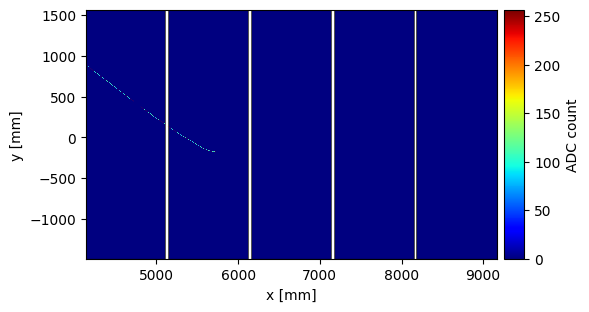

In [23]:
fig,ax = plt.subplots(1,1,tight_layout=True)
plotted_tracks = []
from matplotlib import colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


norm = colors.Normalize(vmin=0, vmax=256)
cmap = cm.jet

m = cm.ScalarMappable(norm=norm, cmap=cmap)
module_ids = []

colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for ip,packet in enumerate(f['packets']):
    
    if packet['packet_type'] == 0:
        io_group, io_channel, chip, channel = packet['io_group'], packet['io_channel'], packet['chip_id'], packet['channel_id']
        module_id = (io_group-1)//4
        if module_id not in module_ids:
            module_ids.append(module_id)
        io_group = io_group - (io_group-1)//4*4
        x,y = geometry[(io_group, io_channel, chip, channel)]
        track_ids = f['mc_packets_assn']['track_ids'][ip]
        fractions = f['mc_packets_assn']['fraction'][ip]
        z_offset = tpc_centers[module_id][0]*10
        x_offset = tpc_centers[module_id][2]*10
        y_offset = tpc_centers[module_id][1]*10
        
        rect = plt.Rectangle((x+x_offset, y+y_offset),
                             consts.pixel_pitch*10, consts.pixel_pitch*10,
                             linewidth=0, fc=m.to_rgba(packet['dataword']))

        ax.add_patch(rect)

        for trackid in track_ids:
            if trackid >= 0 and trackid not in plotted_tracks:
                plotted_tracks.append(trackid)
                ax.plot((f['tracks'][trackid]['x_start']*10,f['tracks'][trackid]['x_end']*10),
                        (f['tracks'][trackid]['y_start']*10,f['tracks'][trackid]['y_end']*10),c='r',alpha=0.75,lw=0.1)
                       # (f['tracks'][trackid]['y_start']*10+218.236,f['tracks'][trackid]['y_end']*10+218.236),c='r',alpha=0.25)

for track in selected_tracks:
    ax.plot((track['x_start']*10,track['x_end']*10),
            (track['y_start']*10,track['y_end']*10),c='r',alpha=0)

for tpc in consts.tpc_borders:
    tpc_rect = plt.Rectangle((tpc[0][0]*10,tpc[1][0]*10), 972.8, 3040, linewidth=0.1, edgecolor='k', facecolor=cmap(0),zorder=-1)
    ax.add_patch(tpc_rect)

ax.set_aspect("equal")
ax.set_xlabel("x [mm]")
ax.set_ylabel("y [mm]")
ax.add_patch(tpc_rect)
ax.set_xlim(np.min(consts.tpc_borders[:,0,:])*10,np.max(consts.tpc_borders[:,0,:])*10)
ax.set_ylim(np.min(consts.tpc_borders[:,1,:])*10,np.max(consts.tpc_borders[:,1,:])*10)
divider0 = make_axes_locatable(ax)
cax0 = divider0.append_axes("right", size="5%", pad=0.07)
fig.colorbar(m, ax=ax, cax=cax0, label='ADC count')
fig.savefig("mc.pdf")